In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os 
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

In [4]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download = True, transform = transforms.ToTensor() )
testset = torchvision.datasets.MNIST(root='./data', train=False, download = True, transform = transforms.ToTensor())

In [5]:
train_data = trainset.train_data.float() / 255
train_label = trainset.train_labels
test_data = testset.test_data.float() / 255
test_label = testset.test_labels

In [6]:
total_data = torch.cat([train_data, test_data], dim=0)
total_label = torch.cat([train_label, test_label], dim=0)

In [7]:
normal_data = np.compress(np.in1d(total_label,[1,2,3,4,5,6,7,8,9]), 
                          total_data, axis=0)
normal_label = np.compress(np.in1d(total_label,[1,2,3,4,5,6,7,8,9]), 
                           total_label, axis=0)
novel_data = np.compress(np.in1d(total_label,[0]),
                        total_data, axis=0)
novel_label = np.compress(np.in1d(total_label,[0]), 
                         total_label, axis=0)

In [8]:
train_size = int(normal_data.shape[0]*0.6) # 60% train
valid_size = int(normal_data.shape[0]*0.2) # 20% valid
test_size = int(normal_data.shape[0]*0.2) # 20% test

In [9]:
train_data = normal_data[:train_size]
valid_data = normal_data[train_size:train_size+valid_size]
test_data = normal_data[train_size+valid_size:]
train_label = normal_label[:train_size]
valid_label = normal_label[train_size:train_size+valid_size]
test_label = normal_label[train_size+valid_size:]

In [10]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(train_label.shape)
print(valid_label.shape)
print(test_label.shape)

torch.Size([37858, 28, 28])
torch.Size([12619, 28, 28])
torch.Size([12620, 28, 28])
torch.Size([37858])
torch.Size([12619])
torch.Size([12620])


In [11]:
novelty_ratio = 0.35
novelty_size = int(test_data.shape[0]/(1-novelty_ratio))
test_data = torch.cat([test_data, novel_data[:novelty_size]], dim = 0)
test_label = torch.cat([test_label, novel_label[:novelty_size]], dim=0)

In [12]:
print(test_data.shape)
print(test_label.shape)

torch.Size([19523, 28, 28])
torch.Size([19523])


In [13]:
device = torch.device('cpu')

In [14]:
train_data = train_data.view(-1,28*28) # [x , 28 ,28] -> [x, 28*28]
valid_data = valid_data.view(-1,28*28)
test_data = test_data.view(-1,28*28)
train_label = train_label.view(-1,1)
valid_label = valid_label.view(-1,1)
test_label = test_label.view(-1,1)

In [15]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(train_label.shape)
print(valid_label.shape)
print(test_label.shape)

torch.Size([37858, 784])
torch.Size([12619, 784])
torch.Size([19523, 784])
torch.Size([37858, 1])
torch.Size([12619, 1])
torch.Size([19523, 1])


In [60]:
train_label

tensor([[5],
        [4],
        [1],
        ...,
        [2],
        [7],
        [1]])

In [16]:
trainset = torch.cat([train_data, train_label.float()], dim=1)
validset = torch.cat([valid_data, valid_label.float()], dim=1)
testset = torch.cat([test_data, test_label.float()], dim=1)

In [17]:
batch_size = 256
trainset = DataLoader(train_data, batch_size = batch_size, shuffle=True)
validset = DataLoader(valid_data, batch_size = 1000, shuffle=True)
testset = DataLoader(testset, batch_size = 1000, shuffle=True)

In [61]:
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 30
learning_rate = 1e-3

class VAE(nn.Module):
    def __init__(self, image_size = 784, h_dim = 400, z_dim = 20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
    
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu+eps*std
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return self.fc5(h)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


In [62]:
for x in trainset:
    print(x.shape)
    break

torch.Size([256, 784])


In [63]:
best_reconst_loss = 99999999999999999
train_loss = []
valid_loss = []
test_loss = []
for epoch in range(num_epochs):
    tmp= 0
    cnt = 0
    for i, x in enumerate(trainset):
        x_reconst, mu, log_var = model(x)
        
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
        tmp  += reconst_loss.item()
        cnt += 1
        kl_div = -0.5 * torch.sum(1+log_var- mu.pow(2) - log_var.exp())
        
        loss = reconst_loss+kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        if (i+1) % 10 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                 .format(epoch+1, num_epochs, i+1, len(trainset), reconst_loss.item(), kl_div.item()))
    train_loss += [tmp/cnt]
    
    valid_reconst_loss = 0
    cnt = 0
    for j, y in enumerate(validset):
        y_reconst, _, _ = model(y)
        valid_reconst_loss += F.mse_loss(y_reconst, y, size_average=False)
        cnt += 1
    valid_loss = [valid_loss, valid_reconst_loss.item()/cnt]
    if (valid_reconst_loss < best_reconst_loss):
        best_model = model
        best_reconst_loss = valid_reconst_loss
        
    with torch.no_grad():
        test_reconst_loss = 0
        cnt = 0
        for i, x in enumerate(testset):
            label = x[:,784]
            x = x[:,:784]
            x_reconst, mu, log_var = best_model(x)
            
            reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
            cnt += 1
            test_reconst_loss += reconst_loss.item()
        test_loss += [test_reconst_loss/cnt]
    print("train_loss :", train_loss[epoch], "test_loss :", test_loss[epoch])

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/30], Step [10/148], Reconst Loss: 14910.4912, KL Div: 1709.6306
Epoch[1/30], Step [20/148], Reconst Loss: 14245.1777, KL Div: 1466.5925
Epoch[1/30], Step [30/148], Reconst Loss: 13159.5215, KL Div: 1129.3564
Epoch[1/30], Step [40/148], Reconst Loss: 11818.0088, KL Div: 1085.5063
Epoch[1/30], Step [50/148], Reconst Loss: 11350.5244, KL Div: 1241.6716
Epoch[1/30], Step [60/148], Reconst Loss: 10956.9346, KL Div: 1330.9694
Epoch[1/30], Step [70/148], Reconst Loss: 9887.4453, KL Div: 1475.9283
Epoch[1/30], Step [80/148], Reconst Loss: 9572.9170, KL Div: 1681.7631
Epoch[1/30], Step [90/148], Reconst Loss: 9543.0254, KL Div: 1724.1128
Epoch[1/30], Step [100/148], Reconst Loss: 9166.7451, KL Div: 1814.8325
Epoch[1/30], Step [110/148], Reconst Loss: 8828.0654, KL Div: 1850.2240
Epoch[1/30], Step [120/148], Reconst Loss: 8456.3506, KL Div: 1791.2833
Epoch[1/30], Step [130/148], Reconst Loss: 8804.5576, KL Div: 1852.1927
Epoch[1/30], Step [140/148], Reconst Loss: 8060.9761, KL Div: 1970.

Epoch[8/30], Step [110/148], Reconst Loss: 5827.9941, KL Div: 2663.0105
Epoch[8/30], Step [120/148], Reconst Loss: 5730.9287, KL Div: 2679.3757
Epoch[8/30], Step [130/148], Reconst Loss: 5863.6890, KL Div: 2673.4041
Epoch[8/30], Step [140/148], Reconst Loss: 5771.9346, KL Div: 2620.0916
train_loss : 5784.863545185811 test_loss : 26960.381396484376
Epoch[9/30], Step [10/148], Reconst Loss: 5762.8467, KL Div: 2551.1548
Epoch[9/30], Step [20/148], Reconst Loss: 5701.7847, KL Div: 2642.8545
Epoch[9/30], Step [30/148], Reconst Loss: 5614.7363, KL Div: 2672.1494
Epoch[9/30], Step [40/148], Reconst Loss: 5934.6978, KL Div: 2653.8779
Epoch[9/30], Step [50/148], Reconst Loss: 5853.0151, KL Div: 2590.1536
Epoch[9/30], Step [60/148], Reconst Loss: 5448.4595, KL Div: 2592.5586
Epoch[9/30], Step [70/148], Reconst Loss: 5770.7617, KL Div: 2634.7842
Epoch[9/30], Step [80/148], Reconst Loss: 5713.4033, KL Div: 2557.4189
Epoch[9/30], Step [90/148], Reconst Loss: 5665.8657, KL Div: 2543.8350
Epoch[9/30]

Epoch[16/30], Step [50/148], Reconst Loss: 5499.3770, KL Div: 2659.0552
Epoch[16/30], Step [60/148], Reconst Loss: 5421.1279, KL Div: 2644.7993
Epoch[16/30], Step [70/148], Reconst Loss: 5299.8750, KL Div: 2607.6143
Epoch[16/30], Step [80/148], Reconst Loss: 5486.2568, KL Div: 2608.1404
Epoch[16/30], Step [90/148], Reconst Loss: 5503.6270, KL Div: 2671.8789
Epoch[16/30], Step [100/148], Reconst Loss: 5433.2139, KL Div: 2724.9434
Epoch[16/30], Step [110/148], Reconst Loss: 5604.0737, KL Div: 2640.0745
Epoch[16/30], Step [120/148], Reconst Loss: 5343.8418, KL Div: 2701.4805
Epoch[16/30], Step [130/148], Reconst Loss: 5609.1689, KL Div: 2821.9563
Epoch[16/30], Step [140/148], Reconst Loss: 5530.8154, KL Div: 2613.4109
train_loss : 5400.796277845228 test_loss : 25374.53408203125
Epoch[17/30], Step [10/148], Reconst Loss: 5472.2476, KL Div: 2713.6677
Epoch[17/30], Step [20/148], Reconst Loss: 5465.7456, KL Div: 2696.8298
Epoch[17/30], Step [30/148], Reconst Loss: 5471.6201, KL Div: 2730.485

Epoch[23/30], Step [140/148], Reconst Loss: 5453.4390, KL Div: 2713.7427
train_loss : 5234.064730257602 test_loss : 25065.456005859374
Epoch[24/30], Step [10/148], Reconst Loss: 5246.2612, KL Div: 2687.4470
Epoch[24/30], Step [20/148], Reconst Loss: 4929.4072, KL Div: 2688.0552
Epoch[24/30], Step [30/148], Reconst Loss: 5056.8643, KL Div: 2647.7634
Epoch[24/30], Step [40/148], Reconst Loss: 5202.7300, KL Div: 2687.7334
Epoch[24/30], Step [50/148], Reconst Loss: 5177.0615, KL Div: 2736.9475
Epoch[24/30], Step [60/148], Reconst Loss: 5185.5991, KL Div: 2734.7986
Epoch[24/30], Step [70/148], Reconst Loss: 5073.8726, KL Div: 2755.2161
Epoch[24/30], Step [80/148], Reconst Loss: 5270.1533, KL Div: 2779.8892
Epoch[24/30], Step [90/148], Reconst Loss: 5207.9502, KL Div: 2712.8711
Epoch[24/30], Step [100/148], Reconst Loss: 5092.7993, KL Div: 2729.0596
Epoch[24/30], Step [110/148], Reconst Loss: 5294.8838, KL Div: 2662.7344
Epoch[24/30], Step [120/148], Reconst Loss: 5495.9492, KL Div: 2641.708

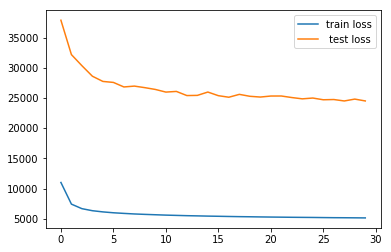

In [65]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train loss',' test loss'])
plt.show()